# Hydrological Model Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MLGLUE
import time as time_module

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1)

## Load Data
- data are obtained from [Gauch et al. (2020)](https://doi.org/10.5281/zenodo.4072701)
- hourly time series of hydrological forcing and discharge

In [4]:
# load data
df = pd.read_csv(
    "./data/forcing.csv",
    parse_dates=[0],
    usecols=[0, 4, 8, 9],
    index_col=0
)
df_flow = pd.read_csv(
    "./data/flow.csv",
    parse_dates=[0],
    usecols=[0, 1, 6],
    index_col=0
)

et_data = df.iloc[:, 0]
et_data = np.where(et_data < 0, 0., et_data)

In [5]:
# prepare time series
start_, end_ = "2009-10-01", "2010-09-30"

p_series = pd.Series(
    data=df.iloc[:, 2],
    index=pd.DatetimeIndex(df.index)
).truncate(before=start_, after=end_).interpolate() # mm/d
et_series = pd.Series(
    data=et_data,
    index=pd.DatetimeIndex(df.index)
).truncate(before=start_, after=end_).interpolate() # mm/d
qout_series = pd.Series(
    data=df_flow.iloc[:, 0],
    index=pd.DatetimeIndex(df.index)
).truncate(before=start_, after=end_).interpolate() # mm/d

# model info
# steps are needed to select time steps for evaluation / likelihood
# computation
steps = [1, 2, 4]
# instead of pandas series we pass 1D arrays to the model
p_series_euler = p_series.copy().values
pet_series_euler = et_series.copy().values

## Create HYMOD Model
- we use the forward Euler method for solving the ODEs

In [6]:
def hymod_euler(Precip, PET, smax, beta, alpha, k_slow, k_quick, step=1):
    """
    An implementation of the HYMOD model using the forward Euler method to
    solve the ODEs.
    See here for governing equations:
    https://superflexpy.readthedocs.io/en/latest/popular_models.html#hymod

    Parameters
    ----------
    Precip : np.ndarray
        The precipitation data in the form of a 1D array.
    PET : np.ndarray
        The potential evapotranspiration data in the form of a 1D array.
    smax : float
        Maximum storage capacity.
    beta : float
        Soil storage distribution coefficient.
    alpha : float
        A fraction (0 <= alpha <= 1) of how much flow to route through the
        quick storages. The remaining portion is routed through the slow
        storage.
    k_slow : float
        Storage coefficient of the slow reservoir.
    k_quick : float
        Storage coefficients of the quick reservoirs.
    step : int
        The step size of the Euler method.

    Returns
    -------
    outflow : np.ndarray
        The computed outflow as 1D array. Has the same length as the input
        forcings.
    """
    # initialize states
    s_upper_zone = 1.
    s_slow = 1.
    s_quick = [1., 1., 1.]
    
    # initialize global outflow data structure
    outflow = []
    # get number of time steps
    tmax = len(Precip)
    
    # ensure that step is an integer
    step = int(step)
    # initialize time step
    t = 0
    
    while t < tmax:
        # compute precipitation excess from upper zone
        s_upper_zone, outflow_upper_zone = upper_reservoir_euler(
            state = s_upper_zone,
            inflow = Precip[t],
            pet = PET[t],
            beta = beta,
            smax = smax,
            step = step
        )
        
        # split outflow from upper zone
        inflow_slow = (1 - alpha) * outflow_upper_zone
        inflow_quick = alpha * outflow_upper_zone
        
        # compute slow reservoir contribution to global outflow
        s_slow, outflow_slow = linear_reservoir_euler(
            state = s_slow,
            inflow = inflow_slow,
            k = k_slow,
            step = step
        )
        
        # update global outflow
        global_outflow = outflow_slow
        
        # compute contribution of quick reservoir series to global outflow
        for n in range(3):
            s_quick[n], inflow_quick = linear_reservoir_euler(
                state = s_quick[n],
                inflow = inflow_quick,
                k = k_quick,
                step = step
            )
            
        # update global outflow
        global_outflow += inflow_quick
            
        # save global outflow
        outflow.append(global_outflow)
        
        # increment time step index
        t += step
    
    return outflow

def linear_reservoir_euler(state, inflow, k, step):
    """
    Computes state y_(n+1) from state y_(n) using the Euler method
    for a linear reservoir with inflow and storage coefficient k.
    
    Parameters
    ----------
    state : float
        The current state y_(n).
    inflow : float
        The inflow flux [L/T] at time step (n).
    k : float
        Storage coefficient [1/T].
    step : int
        The step size of the Euler method.
    
    Returns
    -------
    new_state : float
        The new state y_(n+1).
    outflow : float
        The outflow from the reservoir.
    """
    
    dSdt = inflow - k * state
    outflow = k * state
    new_state = state + step * dSdt
    
    if new_state < 0.:
        new_state = 0.
        
    if outflow < 0.:
        outflow = 0.
    
    return new_state, outflow

def upper_reservoir_euler(state, inflow, pet, beta, smax, step):
    """
    Computes state y_(n+1) from state y_(n) using the Euler method
    for the HYMOD upper reservoir with inflow, evaporation, maximum
    storage height, and distribution coefficient.
    
    Parameters
    ----------
    state : float
        The current state y_(n).
    inflow : float
        The inflow flux [L/T] at time step (n).
    pet : float
        The potential evapotranspiration flux [L/T] at time step (n).
    beta : float
        The distribution coefficient.
    smax : float
        The maximum storage height [L].
    step : int
        The step size of the Euler method.
    
    Returns
    -------
    new_state : float
        The new state y_(n+1).
    outflow : float
        The outflow from the reservoir.
    """
    
    s_bar = state / smax
    
    if state - pet > 0.:
        pet = pet
    else:
        pet = pet - state
    
    dSdt = inflow - pet - inflow * (1 - min(1, max(0, (1 - s_bar))) ** beta)
    
    outflow = inflow * (1 - min(1, max(0, (1 - s_bar))) ** beta)
    new_state = state + step * dSdt
    
    if new_state < 0.:
        new_state = 0.
        
    if outflow < 0.:
        outflow = 0.
    
    return new_state, outflow

## Create MLGLUE Model Function

In [7]:
def hymod_euler_model(parameters, level, n_levels, run_id):
    """
    The model function for MLGLUE.

    Parameters
    ----------
    parameters : 1D list-like
        The model parameter vector.
    level : int
        The level index.
    n_levels : int
        The total number of levels.
    obs : 1D list-like
        The observations on which to condition the parameters.
    likelihood : callable
        A callable with a likelihood method with which to compute the
        likelihood.
    run_id : int
        A run identifier.

    Returns
    -------
    likelihood_ : float
        Computed likelihood for the current parameter sample.
    results : 1D list-like
        The model results.
    """
    step = 1
    if n_levels == 3:
        if level == 0:
            step = 4
        elif level == 1:
            step = 2
        elif level == 2:
            step = 1
    elif n_levels == 1:
        step = 1
        
    outflow = hymod_euler(
        Precip=p_series_euler,
        PET=pet_series_euler,
        smax=parameters[0],
        beta=parameters[1],
        alpha=parameters[2],
        k_slow=parameters[3],
        k_quick=parameters[4],
        step=step
    )
    
    # resample solution to original frequency via linear interpolation
    outflow = pd.Series(
        outflow, index=p_series.index[::step]
    ).reindex(p_series.index).interpolate().values
    # if level == 0:
    #     outflow += .3
    # if level == 1:
    #     outflow += .1
    
    # return None if there are NaN values in sol
    if np.any(np.isnan(outflow)):
        return None
    else:
        warmup = 24 * 25
        # if we want to have a warmup period like this we have to pass the
        # observations to MLGLUE accordingly (without the warmup period),
        # otherwise there will be an error because the shapes of
        # observations and simulated values don't match
        return outflow[warmup:]

## MLGLUE **without** Bias


No samples provided, using uniform sampling...


2025-01-08 13:45:04,247	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 



Starting tuning with Ray...


Results of variance analysis: 
Correlation between subsequent levels (from lowest to highest level):
   0.93425   (level 0, level 1)
   0.99766   (level 1, level 2)
Note: those values should INCREASE with increasing level indices!


Variances of likelihoods on all levels (from lowest to highest level):
   8392.53384   (level 0)
   9565.19338   (level 1)
   10921.27234   (level 2)
Note: those values should be approximately constant across all levels!


The var. inequality holds between levels  0 and 1: 9565.19338 >= 1.21657e+03
The var. inequality holds between levels  1 and 2: 10921.27234 >= 9.26839e+01

The variance inequality holds between all two subsequent levels!
The cross-level variance decays monotonically!


Results of mean value analysis: 
Mean values of the difference between likelihoods on subsequent levels (from lowest to highest level):
   37.57961   (level 0, level 1)
   2.83748   (level 1, level 2)
Note: those values should DECREASE with in

2025-01-08 13:45:40,022	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 



Starting sampling with Ray...


Sampling finished.


Shape of samples:  (48, 5)
Shape of results:  (48, 8137)
Shape of likelihoods:  (48,)
shape of values:  (48, 8137)


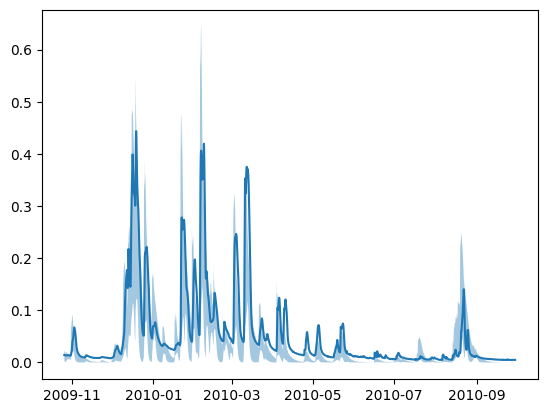

In [8]:
# MLGLUE

# define likelihood
mylike = MLGLUE.InverseErrorVarianceLikelihood(
    threshold=0.1, T=1., weights=None
)

# parameters: [c_max, b_exp, alpha, k_slow, k_quick]

# define warmup
warmup = 24 * 25

mlglue = MLGLUE.MLGLUE(
    likelihood=mylike,
    model=hymod_euler_model,
    upper_bounds=[1000., 2., 1., .1, .5],
    lower_bounds=[1., 0.1, 0., 0., 0.],
    obs=qout_series.values[warmup:],
    n_samples=1_000,
    n_levels=3,
    multiprocessing=True,
    n_processors=4,
    tuning=.2,
    hierarchy_analysis=False,
    include_bias=False
)

samples, liks, results = mlglue.perform_MLGLUE()

print("Shape of samples: ", np.shape(samples))
print("Shape of results: ", np.shape(results))
print("Shape of likelihoods: ", np.shape(liks))

try:
    uncertainty_estimates = mlglue.estimate_uncertainty(
        quantiles=[0.01, 0.5, 0.99]
    )
    
    fig, ax = plt.subplots()
    ax.plot(
        qout_series.index[warmup:],
        qout_series.values[warmup:]
    )
    ax.fill_between(
        qout_series.index[warmup:],
        uncertainty_estimates[:, 0],
        uncertainty_estimates[:, 2],
        alpha=0.4
    )
except:
    pass

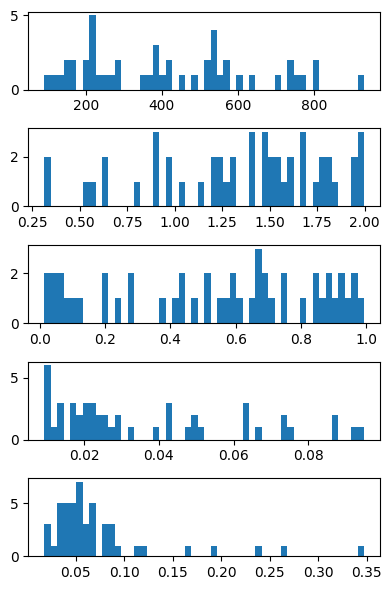

In [9]:
try:
    fig, ax = plt.subplots(nrows=5, figsize=(4, 6))
    
    for i in range(5):
        ax[i].hist(np.array(samples)[:, i], 50)
    
    plt.tight_layout()
except:
    pass

## MLGLUE **with** Bias


No samples provided, using uniform sampling...


2025-01-08 13:47:45,345	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 



Starting tuning with Ray...


Results of variance analysis: 
Correlation between subsequent levels (from lowest to highest level):
   0.93295   (level 0, level 1)
   0.99647   (level 1, level 2)
Note: those values should INCREASE with increasing level indices!


Variances of likelihoods on all levels (from lowest to highest level):
   6143.57304   (level 0)
   5490.85731   (level 1)
   5959.09943   (level 2)
Note: those values should be approximately constant across all levels!


The var. inequality holds between levels  0 and 1: 5490.85731 >= 7.97172e+02
The var. inequality holds between levels  1 and 2: 5959.09943 >= 4.99782e+01

The variance inequality holds between all two subsequent levels!
The cross-level variance decays monotonically!


Results of mean value analysis: 
Mean values of the difference between likelihoods on subsequent levels (from lowest to highest level):
   32.52095   (level 0, level 1)
   1.87731   (level 1, level 2)
Note: those values should DECREASE with incr

2025-01-08 13:48:24,947	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 



Starting sampling with Ray...


Sampling finished.


Shape of samples:  (80, 5)
Shape of results:  (80, 8137)
Shape of likelihoods:  (80,)
shape of values:  (80, 8137)


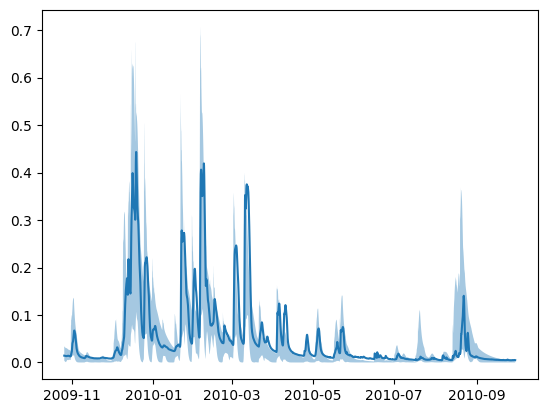

In [11]:
# MLGLUE

# define likelihood
mylike = MLGLUE.InverseErrorVarianceLikelihood(
    threshold=0.1, T=1., weights=None
)

# parameters: [c_max, b_exp, alpha, k_slow, k_quick]
mlglue = MLGLUE.MLGLUE(
    likelihood=mylike,
    model=hymod_euler_model,
    upper_bounds=[1000., 2., 1., .1, .5],
    lower_bounds=[1., 0.1, 0., 0., 0.],
    obs=qout_series.values[warmup:],
    n_samples=1_000,
    n_levels=3,
    multiprocessing=True,
    n_processors=4,
    tuning=.2,
    hierarchy_analysis=False,
    include_bias=True
)

samples, liks, results = mlglue.perform_MLGLUE()

print("Shape of samples: ", np.shape(samples))
print("Shape of results: ", np.shape(results))
print("Shape of likelihoods: ", np.shape(liks))

try:
    uncertainty_estimates = mlglue.estimate_uncertainty(
        quantiles=[0.01, 0.5, 0.99]
    )
    
    fig, ax = plt.subplots()
    ax.plot(
        qout_series.index[warmup:],
        qout_series.values[warmup:]
    )
    ax.fill_between(
        qout_series.index[warmup:],
        uncertainty_estimates[:, 0],
        uncertainty_estimates[:, 2],
        alpha=0.4
    )
except:
    pass

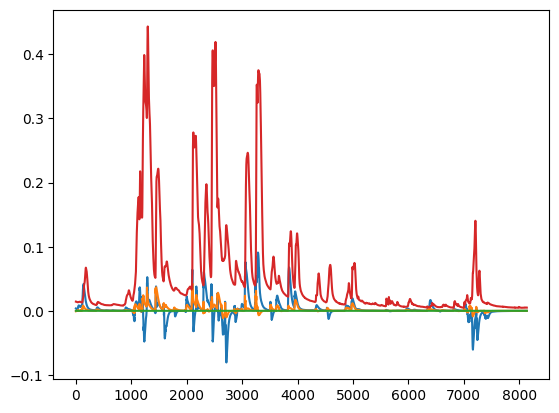

In [12]:
fig, ax = plt.subplots()

ax.plot(mlglue.bias[0])
ax.plot(mlglue.bias[1])
ax.plot(mlglue.bias[2])
ax.plot(
    qout_series.values[warmup:]
)

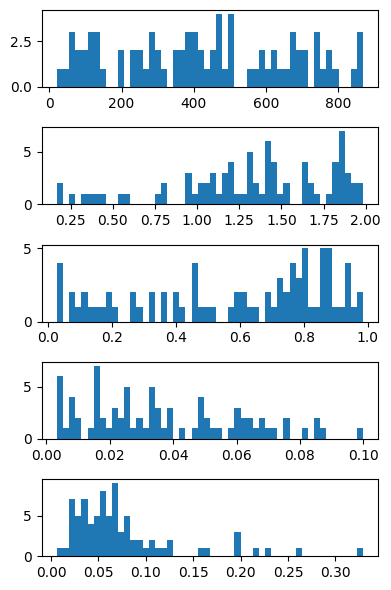

In [13]:
try:
    fig, ax = plt.subplots(nrows=5, figsize=(4, 6))
    
    for i in range(5):
        ax[i].hist(np.array(samples)[:, i], 50)
    
    plt.tight_layout()
except:
    pass